In [15]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
import optuna
import warnings
warnings.filterwarnings('ignore')

In [16]:
os.makedirs('figures', exist_ok=True)

In [2]:
# Load and preprocess data
data = pd.read_csv('clinical_data.csv')
data.dropna(inplace=True)
data = data.drop(columns=["patient_id", "study_id", "histology"])
data = data[data["race"] != "other"]

In [3]:
# Define features
categorical_features = ['sex', 'race', 'stage', 'egfr_mutated',
                        'kras_mutated', 'tp53_mutated', 'smoking_status']
numerical_features = ['age']

for cat_col in categorical_features:
    data[cat_col] = data[cat_col].astype('category')

# Handle rare categories if necessary
for col in categorical_features:
    counts = data[col].value_counts()
    rare_categories = counts[counts < 5].index  # Threshold can be adjusted
    data[col] = data[col].cat.remove_categories(rare_categories)

In [4]:
# Create structured array for survival data
y = np.zeros(len(data), dtype=[('cens', bool), ('time', float)])
y['cens'] = data['survival_status'].astype(bool)
y['time'] = data['survival_months']
X = data.drop(columns=["survival_status", "survival_months"])

# Create preprocessor with drop='first' to avoid multicollinearity
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=data['survival_status']
)

In [6]:
# Define k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
# Optuna optimization for Random Survival Forest
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    rsf = make_pipeline(
        preprocessor,
        RandomSurvivalForest(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        )
    )

    scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = X_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_train_fold = y_train[train_idx]
        y_val_fold = y_train[val_idx]

        rsf.fit(X_train_fold, y_train_fold)
        surv_funcs = rsf.named_steps['randomsurvivalforest'].predict_survival_function(
            rsf.named_steps['columntransformer'].transform(X_val_fold)
        )
        pred = np.array([np.trapz(fn.y, fn.x) for fn in surv_funcs])
        risk_scores = -pred  # Negative expected survival time as risk score
        score = concordance_index_censored(
            y_val_fold['cens'],
            y_val_fold['time'],
            risk_scores
        )[0]
        scores.append(score)

    return np.mean(scores)

In [8]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("\nBest Hyperparameters:", study.best_params)

# Train models with cross-validation
models = {
    'Coxnet': make_pipeline(
        preprocessor,
        CoxnetSurvivalAnalysis(l1_ratio=0.9)  # Adjust l1_ratio as needed
    ),
    'Random Survival Forest': make_pipeline(
        preprocessor,
        RandomSurvivalForest(
            n_estimators=study.best_params['n_estimators'],
            min_samples_split=study.best_params['min_samples_split'],
            min_samples_leaf=study.best_params['min_samples_leaf'],
            random_state=42,
            n_jobs=-1
        )
    ),
    'Elastic Net Cox': make_pipeline(
        preprocessor,
        CoxnetSurvivalAnalysis(l1_ratio=0.5, alpha_min_ratio=0.01)
    )
}

[I 2024-12-03 15:32:55,597] A new study created in memory with name: no-name-7a2b188d-ad5b-4287-b823-8f96742cee7a
[I 2024-12-03 15:32:57,567] Trial 0 finished with value: 0.6442046822377577 and parameters: {'n_estimators': 264, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6442046822377577.
[I 2024-12-03 15:32:58,849] Trial 1 finished with value: 0.645801077442927 and parameters: {'n_estimators': 176, 'min_samples_split': 5, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.645801077442927.
[I 2024-12-03 15:33:00,096] Trial 2 finished with value: 0.6475068371175533 and parameters: {'n_estimators': 180, 'min_samples_split': 12, 'min_samples_leaf': 11}. Best is trial 2 with value: 0.6475068371175533.
[I 2024-12-03 15:33:01,738] Trial 3 finished with value: 0.6466099009182258 and parameters: {'n_estimators': 227, 'min_samples_split': 11, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6475068371175533.
[I 2024-12-03 15:33:04,419] Trial 4 finishe


Best Hyperparameters: {'n_estimators': 258, 'min_samples_split': 19, 'min_samples_leaf': 9}


In [9]:
def get_feature_names(preprocessor, numerical_features, categorical_features):
    """Extract feature names from preprocessor after one-hot encoding"""
    # Get transformed feature names from OneHotEncoder
    onehot = preprocessor.named_transformers_['cat']
    cat_onehot_feature_names = onehot.get_feature_names_out(categorical_features)

    # Combine with numerical features
    feature_names = numerical_features + list(cat_onehot_feature_names)
    return feature_names

# Fit the preprocessor to get feature names
preprocessor.fit(X_train)
feature_names = get_feature_names(preprocessor, numerical_features, categorical_features)

def analyze_correlations(data, target='survival_months'):
    numerical_corr = data.select_dtypes(include=['float64', 'int64']).corr()
    categorical_associations = {}
    categorical_cols = data.select_dtypes(include=['category', 'object']).columns

    for col in categorical_cols:
        contingency_table = pd.crosstab(data[col], data[target] > data[target].median())
        chi2, p_value = stats.chi2_contingency(contingency_table)[0:2]
        categorical_associations[col] = {'chi2': chi2, 'p_value': p_value}

    return numerical_corr, categorical_associations

def plot_survival_by_feature(data, feature, model, preprocessor, times):
    plt.figure(figsize=(10, 6))
    feature_values = data[feature].unique()

    for value in feature_values:
        subset = data[data[feature] == value].copy()
        X_subset = subset[X.columns]  # Use original X columns
        X_subset_transformed = preprocessor.transform(X_subset)
        surv_funcs = model.named_steps['randomsurvivalforest'].predict_survival_function(X_subset_transformed)

        mean_surv = np.mean([fn(times) for fn in surv_funcs], axis=0)
        plt.step(times, mean_surv, where="post", label=f"{feature}={value}")

    plt.xlabel("Time (months)")
    plt.ylabel("Survival probability")
    plt.title(f"Survival Curves by {feature}")
    plt.legend()
    plt.grid(True)

In [10]:
# Evaluate models
results = {}
for name, model in models.items():
    cv_scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = X_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_train_fold = y_train[train_idx]
        y_val_fold = y_train[val_idx]

        try:
            model.fit(X_train_fold, y_train_fold)
        except np.linalg.LinAlgError as e:
            print(f"Failed to fit {name} due to linear algebra error: {e}")
            continue  # Skip to the next fold

        if name == 'Random Survival Forest':
            surv_funcs = model.named_steps['randomsurvivalforest'].predict_survival_function(
                model.named_steps['columntransformer'].transform(X_val_fold)
            )
            pred = np.array([np.trapz(fn.y, fn.x) for fn in surv_funcs])
            risk_scores = -pred  # Negative expected survival time as risk score
        else:
            risk_scores = model.predict(X_val_fold)

        score = concordance_index_censored(
            y_val_fold['cens'],
            y_val_fold['time'],
            risk_scores
        )[0]
        cv_scores.append(score)

    if cv_scores:
        results[name] = {
            'cv_mean': np.mean(cv_scores),
            'cv_std': np.std(cv_scores)
        }
    else:
        results[name] = {
            'cv_mean': None,
            'cv_std': None
        }

    try:
        model.fit(X_train, y_train)
        if name == 'Random Survival Forest':
            surv_funcs = model.named_steps['randomsurvivalforest'].predict_survival_function(
                model.named_steps['columntransformer'].transform(X_test)
            )
            pred = np.array([np.trapz(fn.y, fn.x) for fn in surv_funcs])
            risk_scores = -pred
        else:
            risk_scores = model.predict(X_test)

        test_score = concordance_index_censored(
            y_test['cens'],
            y_test['time'],
            risk_scores
        )[0]
        results[name]['test_score'] = test_score
    except np.linalg.LinAlgError as e:
        print(f"Failed to fit {name} on full training data due to linear algebra error: {e}")
        results[name]['test_score'] = None

In [11]:
# Print results
print("\nModel Performance:")
for name, scores in results.items():
    print(f"\n{name}:")
    if scores['cv_mean'] is not None:
        print(f"CV C-index: {scores['cv_mean']:.3f} ± {scores['cv_std']:.3f}")
    else:
        print("CV C-index: Failed to compute due to singular matrix.")
    if scores['test_score'] is not None:
        print(f"Test C-index: {scores['test_score']:.3f}")
    else:
        print("Test C-index: Failed to compute due to singular matrix.")


Model Performance:

Coxnet:
CV C-index: 0.681 ± 0.026
Test C-index: 0.734

Random Survival Forest:
CV C-index: 0.650 ± 0.044
Test C-index: 0.708

Elastic Net Cox:
CV C-index: 0.681 ± 0.026
Test C-index: 0.734


In [12]:
# Select best model and fit preprocessor
best_model = models['Random Survival Forest']
best_model.fit(X_train, y_train)
preprocessor.fit(X_train)
feature_names = get_feature_names(preprocessor, numerical_features, categorical_features)

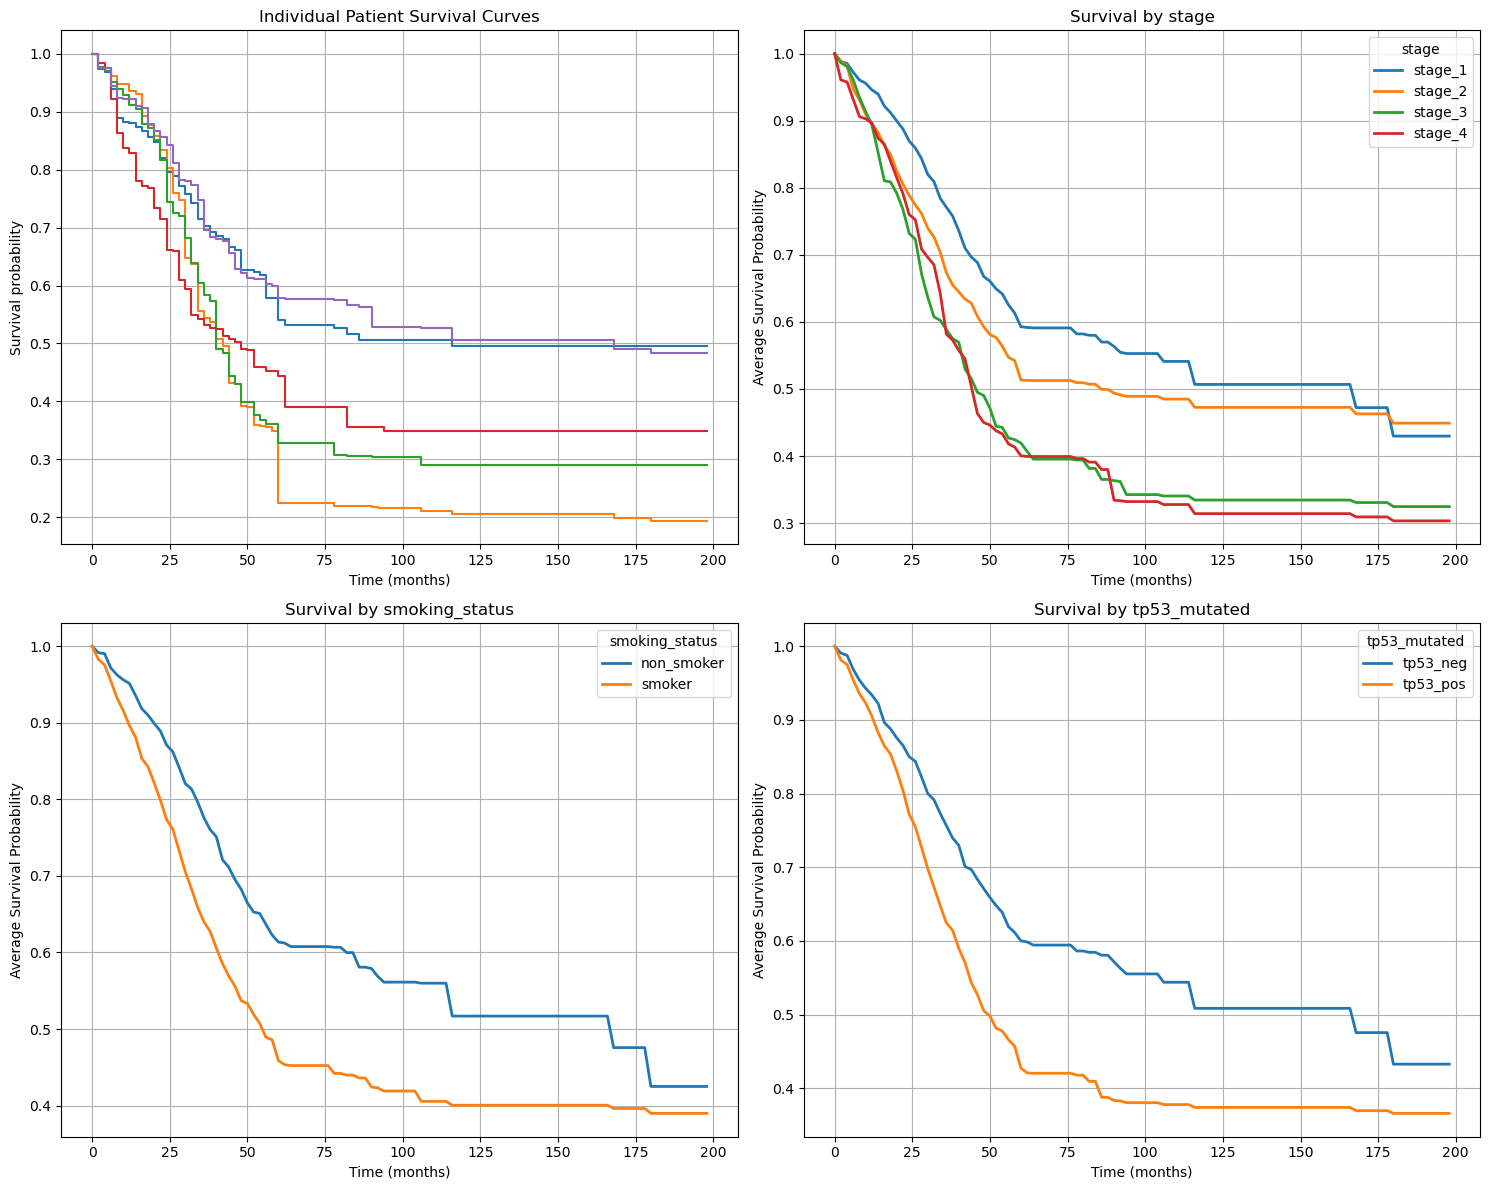

In [25]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# Plot 1: Individual survival curves
times = np.linspace(0, max(y_test['time']), 100)
surv_funcs = best_model.predict_survival_function(X_test)
for surv_func in surv_funcs[:5]:  # Plot first 5 patients
    axes[0].step(times, surv_func(times), where="post")
axes[0].set_xlabel("Time (months)")
axes[0].set_ylabel("Survival probability")
axes[0].grid(True)
axes[0].set_title("Individual Patient Survival Curves")

# Plot survival curves by different features
features = ['stage', 'smoking_status', 'tp53_mutated']
for idx, feature in enumerate(features):
    ax = axes[idx + 1]  # Start from axes[1]
    unique_values = sorted(data[feature].dropna().unique())
    
    for value in unique_values:
        # Get subset of data for this value
        mask = data[feature] == value
        X_subset = data[mask].drop(columns=['survival_months', 'survival_status'])
        
        if not X_subset.empty:
            # Pass raw data to the pipeline
            surv_funcs = best_model.predict_survival_function(X_subset)
            
            # Calculate mean survival curve for this group
            mean_surv = np.mean([sf(times) for sf in surv_funcs], axis=0)
            ax.plot(times, mean_surv, label=str(value), linewidth=2)
        else:
            print(f"No data for {feature} = {value}")
    
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Average Survival Probability")
    ax.grid(True)
    ax.set_title(f"Survival by {feature}")
    ax.legend(title=feature)

# Hide the unused subplot if necessary
if len(features) < len(axes) - 1:
    for idx in range(len(features) + 1, len(axes)):
        fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('figures/survival_rf_curves_by_feature.png')
plt.show()


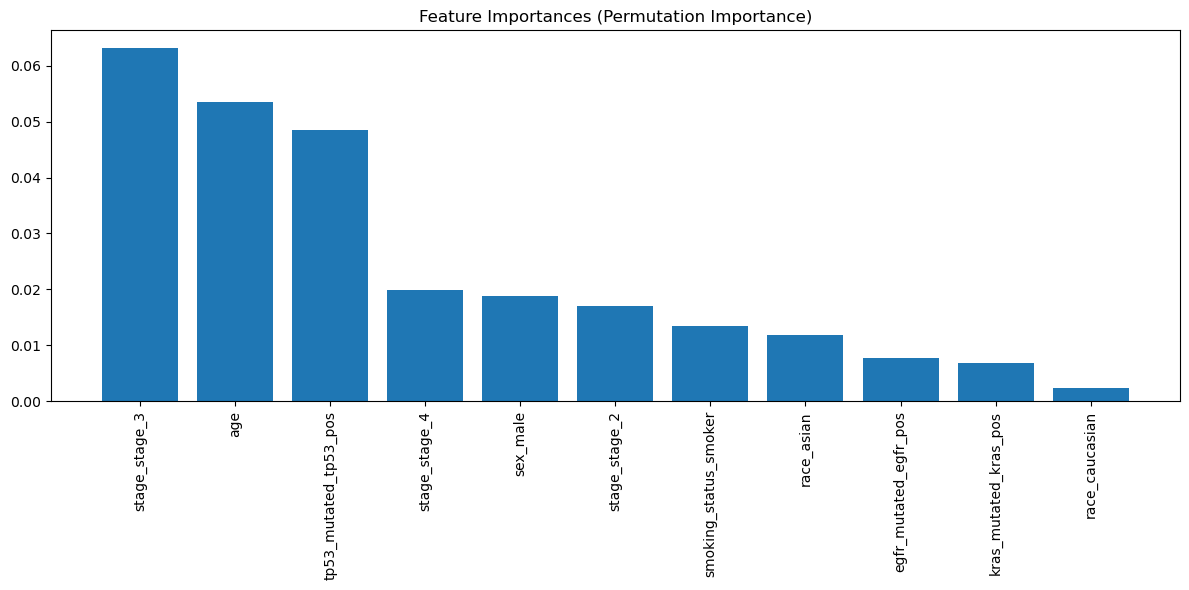

In [24]:
# Compute feature importances using permutation_importance
def concordance_index_scorer(estimator, X, y):
    # For RandomSurvivalForest, we need to use the transformed features
    if isinstance(estimator, RandomSurvivalForest):
        surv_funcs = estimator.predict_survival_function(X)
        pred = np.array([np.trapz(fn.y, fn.x) for fn in surv_funcs])
        risk_scores = -pred
    else:
        risk_scores = estimator.predict(X)
    score = concordance_index_censored(y['cens'], y['time'], risk_scores)[0]
    return score

# We need to wrap our pipeline to use permutation_importance
X_train_transformed = preprocessor.transform(X_train)
rsf_model = best_model.named_steps['randomsurvivalforest']
rsf_model.fit(X_train_transformed, y_train)

result = permutation_importance(
    rsf_model,
    X_train_transformed,
    y_train,
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
    scoring=concordance_index_scorer
)

# Extract mean importances
importances_mean = result.importances_mean

# Now, proceed to plot the feature importances
indices = np.argsort(importances_mean)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Permutation Importance)")
plt.bar(range(len(importances_mean)), importances_mean[indices], align='center')
plt.xticks(range(len(importances_mean)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig('figures/survival_forest_feature_importances.png')
plt.show()